In [ ]:
!pip install radis

In [25]:
import matplotlib.pyplot as plt
from radis import plot_diff, SpectrumFactory, get_residual
from publib import set_style, fix_style
import numpy as np


In [5]:
SAVE=True  # save figs
# Computation parameters
wmin = 2000
wmax = 10000
dv = 0.01
T = 3000.0 #K
p = 0.1 #bar
broadening_max_width=10    # slineshape broadening width, ext



In [6]:
#%% Calculate reference
sf = SpectrumFactory(wavenum_min=wmin, wavenum_max=wmax, 
                  pressure=p,
                  wstep=dv,
                  broadening_max_width=broadening_max_width, 
                  molecule="OH",
                  cutoff=0, # 1e-27,
                  verbose=2,
                  )


In [ ]:
# Fetching data from HITEMP Database and loading in spectrum factory
sf.fetch_databank('hitemp',load_energies=False)


In [11]:
#  Defining variabes to store spectrum
spectra_default = {}
spectra_DLM = {}
spectra_DLM_opt = {}

Nlines_target = [1e2, 1e3, 1e4, 1e5]  # Number of lines in the dataframe df0
Nlines = []


In [9]:
# Finds complement of the lines to drop
def find_missing(lst, N):
    start = 0
    end = N-1
    return sorted(set(range(start, end + 1)).difference(lst))

In [ ]:
for Ntarget in Nlines_target:
    
    # Load HITEMP database for this species/range (433984 rows)
    sf.load_databank('HITEMP-OH',load_energies=False)
    # Reduce number of lines to approximately Nlines:

    rows = np.arange(0,len(sf.df0),max(1,int(len(sf.df0)//Ntarget)))
    rows = find_missing(rows,len(sf.df0))
    rows = sf.df0.index[rows]
    sf.df0.drop(rows, inplace=True)
    #sf.df0 = sf.df0.sample(frac = 0.4)
    #sf.df0 = sf.df0[::max(1,int(len(sf.df0)//Ntarget))]
    N = len(sf.df0)
    Nlines.append(N)
    
    #%% Calculate normal

    sf.params['optimization'] = None
    sf.params['broadening_method'] = 'voigt'
    sf.misc['chunksize'] = 1e7
    s_none = sf.eq_spectrum(300)
    s_none.name = 'Default ({0:.1f}s)'.format(s_none.conditions['calculation_time'])
    spectra_default[N] = s_none

    # %% Calculate DLM
    
    sf.params['optimization'] = "simple"
    sf.params['broadening_method'] = 'fft'
    s_dlm = sf.eq_spectrum(T)
    s_dlm.name = 'New method {0}'.format(s_dlm.conditions['calculation_time'])
    spectra_DLM[N] = s_dlm

    # %% Calculate DLM (optimized)
    
    sf.params['optimization'] = "min-RMS"
    sf.params['broadening_method'] = 'fft'
    s_dlm_opt = sf.eq_spectrum(T)
    s_dlm_opt.name = 'DLM ({0:.1f}s)'.format(s_dlm_opt.conditions['calculation_time'])
    spectra_DLM_opt[N] = s_dlm_opt


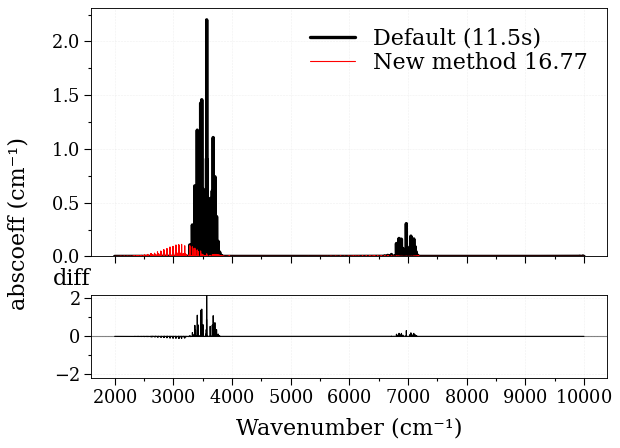

<Figure size 640x480 with 0 Axes>

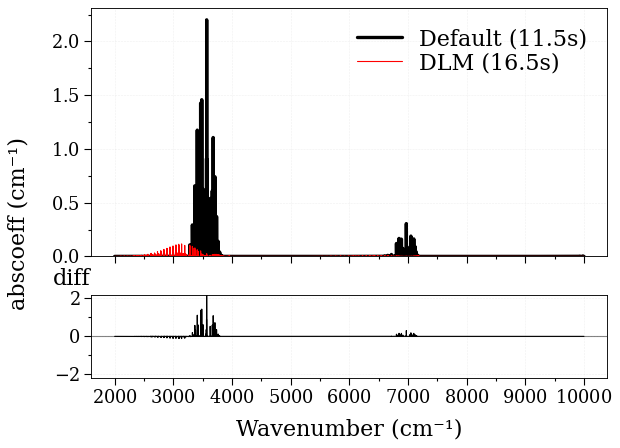

<Figure size 640x480 with 0 Axes>

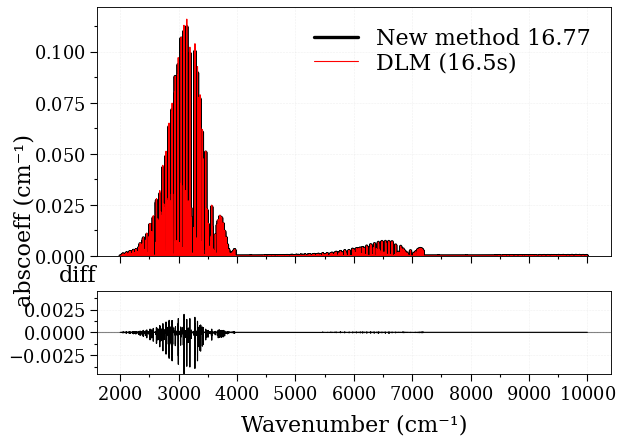

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.





>>>>>> for Article

101 lines
noDLM : 0.3s 	 --> 2.8e+08 lines.points/s
DLM : 17.4s 	 --> 4.7e+06 lines.points/s

1014 lines
noDLM : 1.1s 	 --> 7.7e+08 lines.points/s
DLM : 16.6s 	 --> 4.9e+07 lines.points/s

10131 lines
noDLM : 11.5s 	 --> 7.1e+08 lines.points/s
DLM : 16.5s 	 --> 4.9e+08 lines.points/s

20262 lines
noDLM : 23.1s 	 --> 7.0e+08 lines.points/s
DLM : 16.5s 	 --> 9.8e+08 lines.points/s


<Figure size 640x480 with 0 Axes>

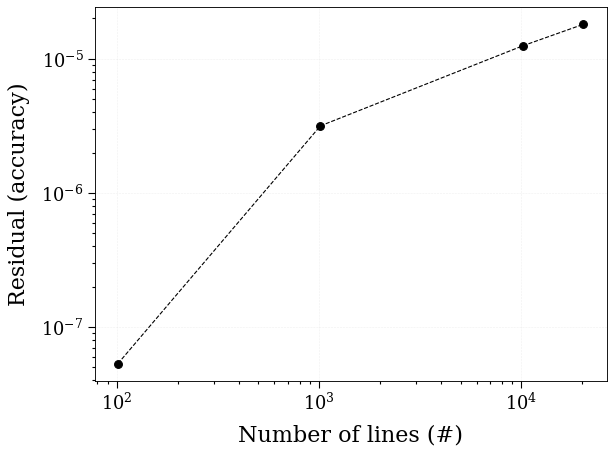

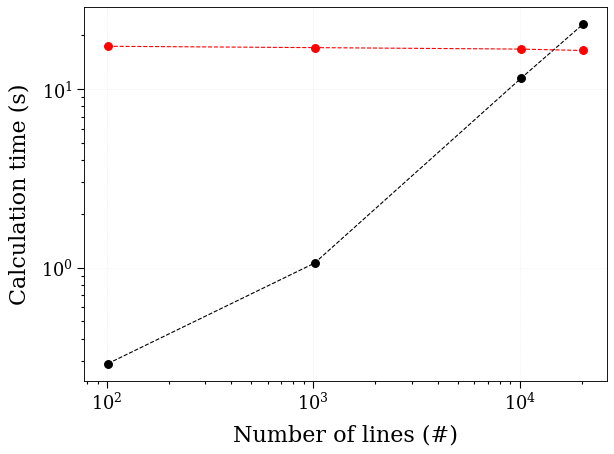

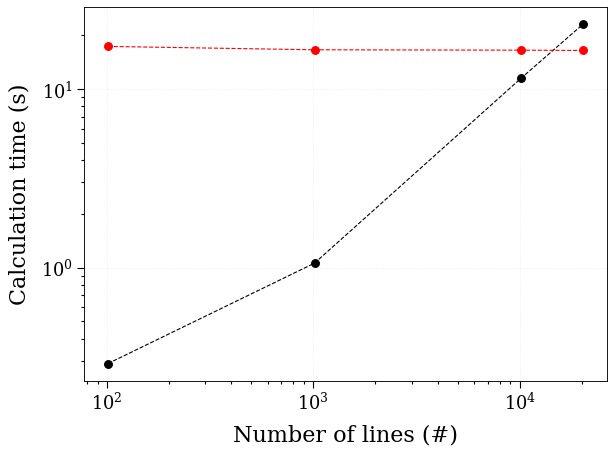

In [23]:
# %% Plot last spectra
plot_diff(spectra_default[N], spectra_DLM[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig6b_DLMpaper_benchmark_Nlines_2spectra.png') 
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig6b_DLMpaper_benchmark_Nlines_2spectra.pdf') 

# %% Plot last spectra (opt)
plot_diff(spectra_default[N], spectra_DLM_opt[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig6_DLMpaper_benchmark_Nlines_2spectra_minRMS.png') 
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig6_DLMpaper_benchmark_Nlines_2spectra_minRMS.pdf') 

# %% Plot last spectra
plot_diff(spectra_DLM[N], spectra_DLM_opt[N], 'abscoeff')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_2spectra_simple_vs_minRMS.png') 
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_2spectra_simple_vs_minRMS.pdf') 

#%% Compare residual
set_style('origin')
plt.figure()
plt.plot(Nlines, [get_residual(spectra_default[N], spectra_DLM_opt[N], 'abscoeff')
                  for N in Nlines], '--ok')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Residual (accuracy)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_residual.png')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_residual.pdf')


#%% Compare performance (simple)
set_style('origin')
plt.figure()
plt.plot(Nlines, [spectra_default[N].conditions['calculation_time'] for N in Nlines], '--ok')
plt.plot(Nlines, [spectra_DLM[N].conditions['calculation_time'] for N in Nlines], '--or')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Calculation time (s)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_time.png')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/DLMpaper_benchmark_Nlines_time.pdf')


#%% Compare performance (opt)
set_style('origin')
plt.figure()
plt.plot(Nlines, [spectra_default[N].conditions['calculation_time'] for N in Nlines], '--ok')
plt.plot(Nlines, [spectra_DLM_opt[N].conditions['calculation_time'] for N in Nlines], '--or')
plt.xlabel('Number of lines (#)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Calculation time (s)')
plt.legend()
fix_style('origin')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig5_DLMpaper_benchmark_Nlines_time_minRMS.png')
if SAVE: plt.savefig('/OH Benchmark 1e2 to 1e5/fig5_DLMpaper_benchmark_Nlines_time_minRMS.pdf')

#%% Data for article

print('\n'*3+'>>>>>> for Article')
for N in Nlines:
    print('\n{0} lines'.format(spectra_default[N].conditions['lines_calculated']))
    print('noDLM : {0:.1f}s \t --> {1:.1e} lines.points/s'.format(
            spectra_default[N].conditions['calculation_time'],
            (len(spectra_default[N].get_wavenumber())*spectra_default[N].conditions['lines_calculated']/
                    spectra_default[N].conditions['calculation_time']),
            ))
    print('DLM : {0:.1f}s \t --> {1:.1e} lines.points/s'.format(
            spectra_DLM_opt[N].conditions['calculation_time'],
            (len(spectra_DLM_opt[N].get_wavenumber())*spectra_DLM[N].conditions['lines_calculated']/
                    spectra_DLM_opt[N].conditions['calculation_time']),
            ))

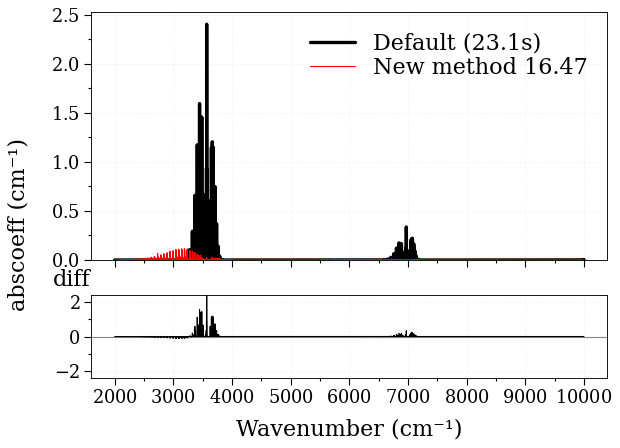

(<Figure size 640x480 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9da51f32d0>])

In [13]:
plot_diff(spectra_default[N], spectra_DLM[N], 'abscoeff')

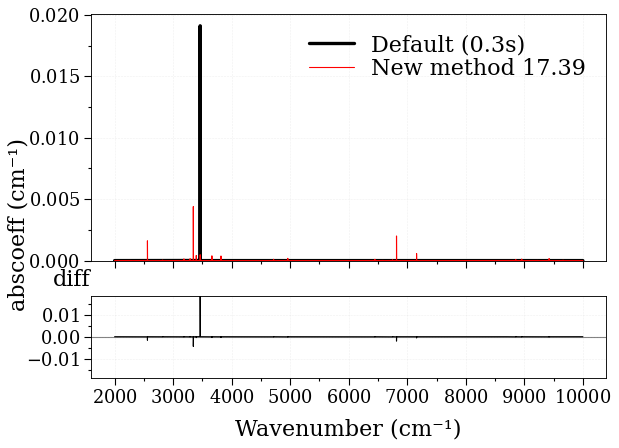

(<Figure size 640x480 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9da196fad0>])

In [19]:
plot_diff(spectra_default[Nlines[0]], spectra_DLM[Nlines[0]], 'abscoeff')

In [28]:
wmin = 2000
wmax = 10000
dv = 0.005
T = 2000.0 #K
p = 0.1 #bar
broadening_max_width=10    # slineshape broadening width, ext
#%% Calculate reference
sf1 = SpectrumFactory(wavenum_min=wmin, wavenum_max=wmax, 
                  pressure=p,
                  wstep=dv,
                  broadening_max_width=broadening_max_width, 
                  molecule="OH",
                  cutoff=0, # 1e-27,
                  verbose=0,
                  )

# Number of lines to be selected from database
Ntarget = 10000
# Load HITEMP database for this species/range (433984 rows)
sf1.load_databank('HITEMP-OH',load_energies=False)
# Reduce number of lines to approximately Nlines:

rows = np.arange(0,len(sf1.df0),max(1,int(len(sf1.df0)//Ntarget)))
rows = find_missing(rows,len(sf1.df0))
rows = sf1.df0.index[rows]
sf1.df0.drop(rows, inplace=True)
N = len(sf1.df0)
#Nlines.append(N)
print(sf1.df0)
#%% Calculate normal

sf1.params['optimization'] = None
sf1.params['broadening_method'] = 'voigt'
sf1.misc['chunksize'] = 1e7
s_none = sf1.eq_spectrum(300)
s_none.name = 'Default ({0:.1f}s)'.format(s_none.conditions['calculation_time'])
#spectra_default[N] = s_none

# %% Calculate DLM

sf1.params['optimization'] = "simple"
sf1.params['broadening_method'] = 'fft'
s_dlm = sf1.eq_spectrum(T)
s_dlm.name = 'New method {0}'.format(s_dlm.conditions['calculation_time'])
#spectra_DLM[N] = s_dlm

# %% Calculate DLM (optimized)

sf1.params['optimization'] = "min-RMS"
sf1.params['broadening_method'] = 'fft'
s_dlm_opt = sf1.eq_spectrum(T)
s_dlm_opt.name = 'DLM ({0:.1f}s)'.format(s_dlm_opt.conditions['calculation_time'])
#spectra_DLM_opt[N] = s_dlm_opt


       id  iso          wav           int  ...          iref  lmix     gp    gpp
0      13    1  1995.037421  2.841000e-68  ...   6 5 2 1 1 0         60.0   60.0
2      13    1  1995.440759  2.826000e-79  ...   6 5 2 1 1 0         68.0   64.0
4      13    1  1995.771504  4.883000e-53  ...   6 5 2 1 1 0        124.0  128.0
6      13    1  1996.134210  2.747000e-68  ...   6 5 2 1 1 0         60.0   60.0
8      13    1  1997.885194  2.159000e-90  ...   6 5 2 1 1 0        168.0  168.0
...    ..  ...          ...           ...  ...           ...   ...    ...    ...
20252  13    1  9996.356481  3.493000e-57  ...   6 5 2 1 1 0         36.0   32.0
20254  13    1  9996.777041  9.394000e-51  ...   6 5 2 1 1 0        100.0  104.0
20256  13    1  9997.304314  2.415000e-68  ...   6 5 2 1 1 0         28.0   28.0
20258  13    1  9997.940870  2.737000e-50  ...   6 5 2 1 1 0         96.0   92.0
20260  13    1  9999.464766  1.162000e-40  ...   6 5 2 1 1 0         84.0   84.0

[10131 rows x 19 columns]


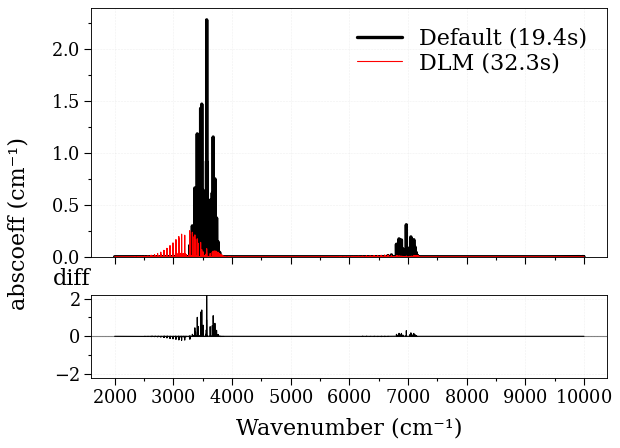

(<Figure size 640x480 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9d955e5290>])

In [29]:
plot_diff(s_none, s_dlm_opt, 'abscoeff')